# Data Quality

This notebook shows some of the data quality functions associated with spectra, based on on 
the standard OnOff observation we have seen before.


You can find a copy of this tutorial as a Jupyter notebook [here](https://github.com/GreenBankObservatory/dysh/blob/main/notebooks/examples/quality.ipynb) or download it by right clicking  <a href="https://raw.githubusercontent.com/GreenBankObservatory/dysh/refs/heads/main/notebooks/examples/quality.ipynb" download>here</a> and selecting "Save Link As".

The following Spectrum functions will be discussed

```
stats         - statistics of a spectrum
roll          - a series of rolls (1,2,3...) to discover channel correlations and/or ripples in the spectrum
radiometer    - adherence of spectrum to the radiometer equation
snr           - signal/noise ratio, either channel or flux based
sratio        - flux ratio, an indiction of a number between -1 and 1, if there is signal, 0 if none.
normalness    - likelyhood noise is a gaussian, returned as a p-value  (p>0.05 means signal is gaussian(
cog           - curve of growth - can be useful to automatically determine where signal is
```

## Loading Modules

We start by loading the modules we will use for the data reduction. 

For display purposes, we use the static (non-interactive) `matplotlib` backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on `jupyter` lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

import numpy as np

# These modules are required for the data reduction.
from dysh.fits.gbtfitsload import GBTFITSLoad
from astropy import units as u
from dysh.util.files import dysh_data
from dysh.spectra.spectrum import Spectrum

## Data Loading

We use the standard **getps** (AGBT05B_047_01) test
and use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [2]:
filename = dysh_data(test="getps")      # AGBT05B_047_01/AGBT05B_047_01.raw.acs
sdfits = GBTFITSLoad(filename)

In [3]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


## Data Reduction

First we extract a (time-averaged) spectrum from the first scan. If you recall from the Position-Switch observation, both edges have some problems, and for the purpose of this we remove some edge channels. We plot this spectrum and perform statistics on the first and last 10000 channels, which look line free in the plot below.


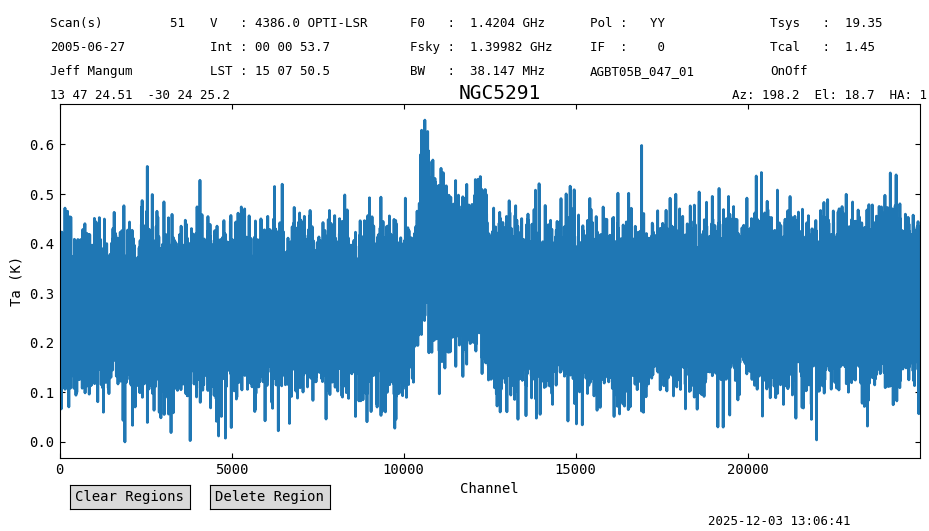

In [4]:
sp1 = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
sp1.plot(xaxis_unit='chan');

In [5]:
#   first 10,000 channels
sp1[:10000].stats()

{'mean': <Quantity 0.26528672 K>,
 'median': <Quantity 0.26475095 K>,
 'rms': <Quantity 0.07121472 K>,
 'min': <Quantity 0.00017927 K>,
 'max': <Quantity 0.55562308 K>,
 'npt': 10000,
 'nan': 0}

In [6]:
#  last 10,000 channels
sp1[-10000:].stats()

{'mean': <Quantity 0.28550266 K>,
 'median': <Quantity 0.28676712 K>,
 'rms': <Quantity 0.07194848 K>,
 'min': <Quantity 0.00420958 K>,
 'max': <Quantity 0.59789101 K>,
 'npt': 10000,
 'nan': 0}

There is a significant continuum visible in the spectrum, plus the two sections on either side of the line clearly have
a diffent continuum level (0.265 vs. 0.286), including possibly a slope.

The RMS levels are very similar, at 0.0712 and 0.0719K resp.


In [7]:
#  using roll=1 (and assuming non-correlated channels) we get a better estimate for the RMS and
#  confirm the values are more consistent with each other
print(sp1[:10000].stats(roll=2)["rms"]/np.sqrt(2))
print(sp1[-10000:].stats(roll=2)["rms"]/np.sqrt(2))

0.07129852614846216 K
0.0711756392881234 K


## Roll

Rolling the data, and comparing the RMS can tell us if there are channel-to-channel correlations, but they are also affected by
slow variations as is the case with this spectrum.  

We thus compare the first and second half


In [8]:
sp1[:10000].roll(4)

[1.0135264176511074,
 0.9988245936948404,
 1.0009603161121046,
 1.0088321962353017]

In [9]:
sp1[-10000:].roll(4)

[0.9999156101763855, 1.010858225761961, 1.0084001992327756, 0.9975490040561179]

Here one can argue there is no correllation between channels, and there is little variation in the baseline.

##  Radiometer Equation

For a given $T_{sys}$, channel width $\Delta f$ and observing time $\Delta t$ the radiometer equation predicts the expected noise as:
$$
  \Delta T = {  { T_{sys} } \over \sqrt{ \Delta f .  \Delta t } }
$$
The `radiometer()` function will return the ratio of the measured noise to this expected noise, and is normally a number close to 1, but perhaps a bit larger.

In [10]:
sp1.radiometer()

1.125255087134089

Over the full spectrum it is clearly off at 1.125, so it needs to be measured at both ends, where we see it is better, but not close.

In [11]:
print(sp1[:10000].radiometer(), sp1[-10000:].radiometer())

1.0534482472856415 1.064302424008175


wheras as "fake spectrum" does a lot better. The variation of the ratio varies as $1/\sqrt{N}$. Experiments showed
that for nchan=32768 the RMS in this ratio is about 0.004.

In [12]:
Spectrum.fake_spectrum(nchan=32768, seed=123).radiometer()

1.000493959432403

## Baseline Subtraction

To avoid all this confusion of a continuum, and we have seen this before, as baseline subtraction should
be done. For this, lets define the line emission to be between channels 10000 and 13000. In the interactive
version one can more accurately determine the range of line emission channels.

{'mean': <Quantity 0.00742555 K>,
 'median': <Quantity 0.00620263 K>,
 'rms': <Quantity 0.07572969 K>,
 'min': <Quantity -0.28504302 K>,
 'max': <Quantity 0.37799223 K>,
 'npt': 25000,
 'nan': 0}

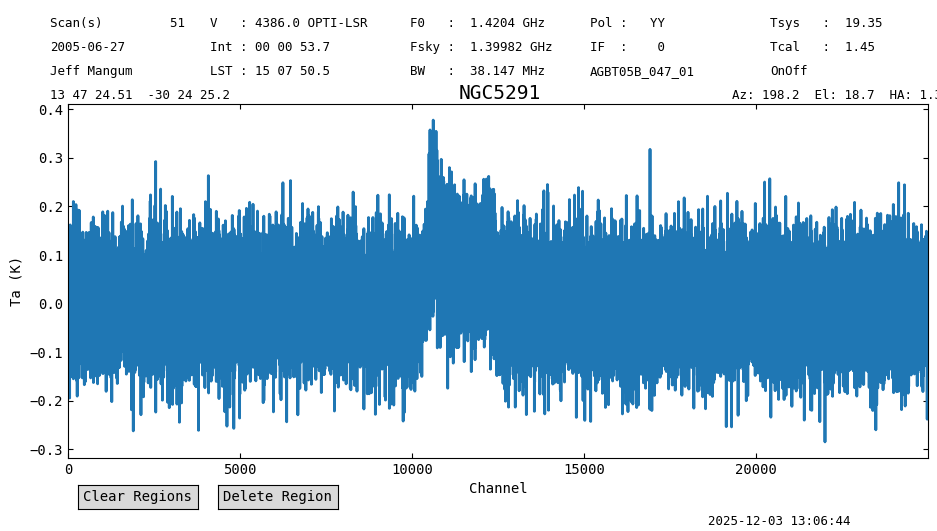

In [13]:
sp1.baseline(2,exclude=[10000,13000], remove=True)
sp1.plot(xaxis_unit='chan')
sp1.stats()

In [14]:
# redo the tests
print(sp1[:10000].stats())
print(sp1[:10000].stats(roll=1))
print("ROLL",sp1[:10000].roll(4))


print(sp1[-10000:].stats())
print(sp1[-10000:].stats(roll=1))
print("ROLL",sp1[-10000:].roll(4))

{'mean': <Quantity -2.2629703e-05 K>, 'median': <Quantity -0.00075626 K>, 'rms': <Quantity 0.07116938 K>, 'min': <Quantity -0.26237535 K>, 'max': <Quantity 0.29259241 K>, 'npt': 10000, 'nan': 0}
{'mean': <Quantity -1.9197046e-06 K>, 'median': <Quantity -0.00102835 K>, 'rms': <Quantity 0.09936872 K>, 'min': <Quantity -0.37160137 K>, 'max': <Quantity 0.35925086 K>, 'npt': 9998, 'nan': 0}
ROLL [1.0128811828407969, 0.998188719261976, 1.0003230836163934, 1.0081899537964756]
{'mean': <Quantity -0.00022584 K>, 'median': <Quantity 0.00077847 K>, 'rms': <Quantity 0.071728 K>, 'min': <Quantity -0.28504302 K>, 'max': <Quantity 0.31773396 K>, 'npt': 10000, 'nan': 0}
{'mean': <Quantity 1.49875702e-05 K>, 'median': <Quantity 7.22095017e-06 K>, 'rms': <Quantity 0.1017591 K>, 'min': <Quantity -0.36167572 K>, 'max': <Quantity 0.36903475 K>, 'npt': 9998, 'nan': 0}
ROLL [0.9968514887965323, 1.0077605734857915, 1.0053100806485058, 0.9944921396141728]


Curious how the radiometer equation holds as function of time?

In [15]:
for scan in [51,53,55,57]:
    sp2 = sdfits.getps(scan=scan, ifnum=0, plnum=0, fdnum=0).timeaverage()[5000:30000]
    print(scan, sp2[:10000].radiometer(), sp2[-10000:].radiometer())

51 1.0534482472856415 1.064302424008175
53 1.0403504063163798 1.0625099986152131
55 1.058371483573899 1.0546632153917312
57 1.0434733004644334 1.05796537199034


So we can conclude it did not change behavior during this observation, but there is a clean 5% deviation from an ideal telescope.

## snr:   Signal to Noise ratio

This can be done in two ways:  channel based and flux based. For the latter a section of spectrum where the signal is expected has to be selected

For pure noise in a channel based comparision (the default) we would expect the `snr` to be around 4, higher for higher number of channels, as can be computed via the error function.


In [16]:
sp1[:10000].snr()

4.164491122535507

In [17]:
sp1[-10000:].snr()

4.418897674363033

In [18]:
sp1[10000:13000].snr()


4.445639310616525

In [19]:
print(sp1[:10000].snr(flux=True))
print(sp1[-10000:].snr(flux=True))
print(sp1[10000:13000].snr(flux=True))

-0.03220654566881452
-0.3138716517803448
47.657354295387066


## sratio:  Signal Ratio

The signal ratio is defined as the difference between the positive and negative sum of the signals, normalized by the sum of both. This results in a dimensionless number between -1 and 1, where -1 means a pure absorption signal, 0 pure noise, and 1 pure emission line:
$$
     S_r = {{ P_{sum}+ N_{sum} } \over {P_{sum} - N_{sum}}}
$$
note that $N_{sum}$ is negative.

In [20]:
sp1[:10000].sratio()

-0.00039926888385282615

In [21]:
sp1[-10000:].sratio()

-0.003947589303416983

In [22]:
sp1[10000:13000].sratio()

0.7404518588445785

## Normalness

A function (to be written) that gives a likelyhood the noise is distribution like a gaussian. The method we use
here is the Anderson-Darling statistic, returning the p-value of the likelyhood the noise is gaussian.

In [23]:
sp1.normalness()

3.5572437509058872e-12

Obviously because the signal was in the spectrum, this very small p-value indicates a strong deviation from gaussian noise.
Let us look at the two wings as before, and confirm the noise is gaussian:

In [24]:
print(sp1[:10000].normalness())
print(sp1[-10000:].normalness())

0.7699068784061844
0.3140908185449788


These p-values are > 0.05, indicating the noise is well characterised by a gaussian.

## Smoothing

Smoothing should give us a much clearer detection. Lets see how the previous measures live of to this task.

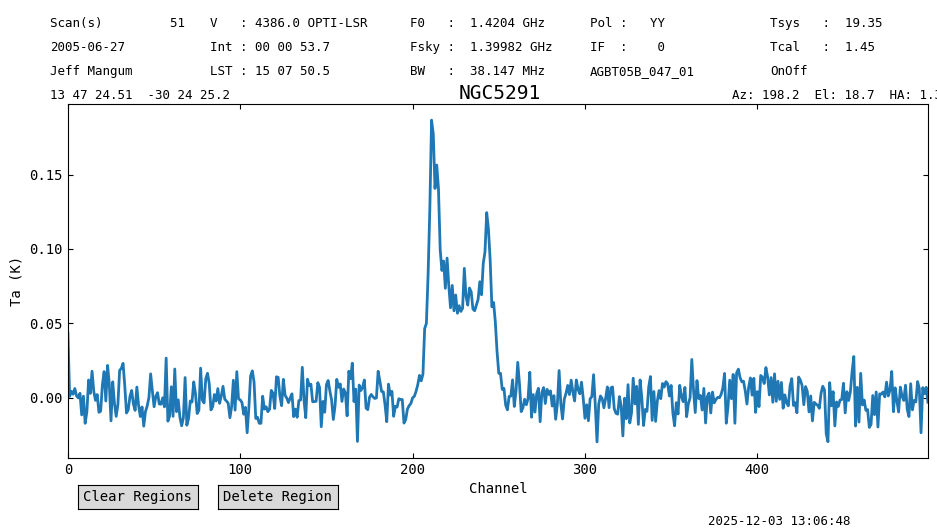

In [25]:
n=50
sp1s = sp1.smooth('hanning',n)    # pick between hanning, box and gauss
sp1s.plot(xaxis_unit='chan')

Lets print the RMS for this smoothed signal. Unsmoothed we found 0.07 K so we should expect $\sqrt{50}$ better, or about 0.01 K.

In [26]:
print(sp1s[:200].stats()["rms"], sp1s[-200:].stats()["rms"])

0.010752784789192022 K 0.010549863737707773 K


In [27]:
# print(sp1s.radiometer())
print(sp1s[:200].radiometer())
print(sp1s[-200:].radiometer())

1.1247328535675043
1.1035074707704635


It seems even with roll=1 (where the best RMS is obtained) the ratio is a bit far from ideal.
This indicated there is something wrong with smoothing, worthy of an issue.

In [28]:
print(sp1s[:200].snr(peak=True), sp1s[:200].snr(peak=False), 'left side')
print(sp1s[-200:].snr(peak=True), sp1s[-200:].snr(peak=False), 'right side')
print(sp1s[200:260].snr(peak=True), sp1s[200:250].snr(peak=False), 'signal portion')

4.484230544311234 3.01577980989871 left side
2.641517335961263 2.7987663493080124 right side
9.702435801524112 5.336628917119453 signal portion


In [29]:
print(sp1s[:200].snr(flux=True), 'left side')
print(sp1s[-200:].snr(flux=True), 'right side')
print(sp1s[200:260].snr(flux=True), 'signal portion')

-0.15450025700383882 left side
-0.2420249361659453 right side
37.169403961327866 signal portion


In [30]:
sp1s[200:250].sratio()

0.9999545959682958

The Curve of Growth method also lists lots of interesting properties that can be used in some of the quality assessment functions we have discussed above. Notably the bchan and echan can be used to differentiate line from continuum.

In [31]:
sp1s.cog()

{'flux': <Quantity 60.75483749 K km / s>,
 'flux_std': <Quantity 1.67196751 K km / s>,
 'flux_r': <Quantity 29.40096493 K km / s>,
 'flux_r_std': <Quantity 1.94644771 K km / s>,
 'flux_b': <Quantity 31.41728441 K km / s>,
 'flux_b_std': <Quantity 1.46281974 K km / s>,
 'width': {0.25: <Quantity 215.4868403 km / s>,
  0.65: <Quantity 447.54977747 km / s>,
  0.75: <Quantity 513.85353672 km / s>,
  0.85: <Quantity 580.15733259 km / s>,
  0.95: <Quantity 679.61310541 km / s>},
 'width_std': {0.25: <Quantity 33.22178748 km / s>,
  0.65: <Quantity 16.80630176 km / s>,
  0.75: <Quantity 33.54775629 km / s>,
  0.85: <Quantity 33.65571145 km / s>,
  0.95: <Quantity 33.8413805 km / s>},
 'A_F': 1.0685800443739804,
 'A_C': 1.2116639238263323,
 'C_V': 2.6923098031876593,
 'rms': <Quantity 0.01055038 K>,
 'bchan': 185,
 'echan': 267,
 'vel': <Quantity 4382.45068124 km / s>,
 'vel_std': <Quantity 440.84330593 km / s>}